<a href="https://colab.research.google.com/github/danendrafau/customer-segmentation/blob/main/%5BClustering%5D_Submission_Akhir_BMLP_Danendra_Fahar_Utama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**: Kaggle - [Shop Customer Data](https://www.kaggle.com/datasets/datascientistanna/customers-dataset/) (sesuai rekomendasi dicoding)
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [114]:
#load dataset
data = pd.read_csv("https://raw.githubusercontent.com/danendrafau/customer-segmentation/refs/heads/main/input_data/customers.csv")

#preview data
print(data.head())

   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  
0     Healthcare                1            4  
1       Engineer                3            3  
2       Engineer                1            1  
3         Lawyer                0            2  
4  Entertainment                2            6  


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [115]:
#hapus CustomerID
data = data.drop('CustomerID', axis=1)

In [116]:
#rename kolom
data.rename(columns={'Annual Income ($)': 'annual_income',
                     'Spending Score (1-100)': 'spending_score',
                     'Work Experience': 'work_experience',
                     'Family Size': 'family_size'}, inplace=True)

In [117]:
#cek duplikat
print('Jumlah data duplikat: ', data.duplicated().sum())

#cek missing values
print('Jumlah missing value:')
print(data.isnull().sum())

Jumlah data duplikat:  0
Jumlah missing value:
Gender              0
Age                 0
annual_income       0
spending_score      0
Profession         35
work_experience     0
family_size         0
dtype: int64


In [118]:
#isi missing values dengan "Other"
data['Profession'] = data['Profession'].fillna('Other')

In [119]:
#cek ulang missing values
print('Jumlah missing value:')
print(data.isnull().sum())

Jumlah missing value:
Gender             0
Age                0
annual_income      0
spending_score     0
Profession         0
work_experience    0
family_size        0
dtype: int64


**NOTE:**

Data missing sudah hilang.

Empty DataFrame
Columns: [Gender, Age, annual_income, spending_score, Profession, work_experience, family_size]
Index: []


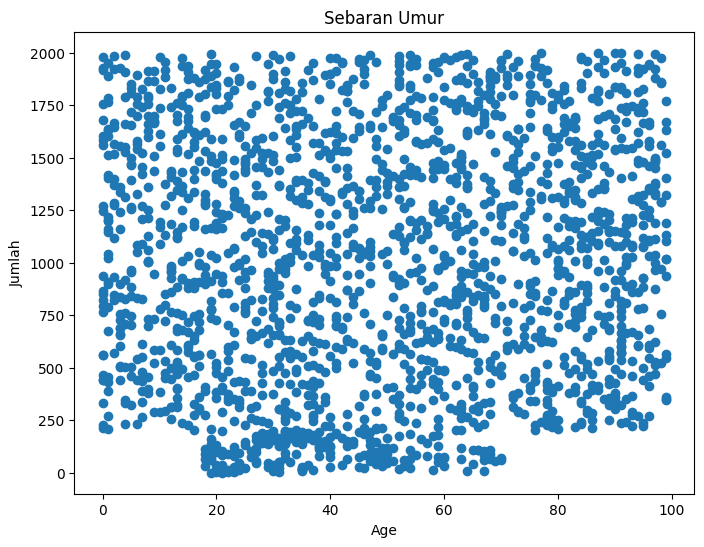

In [111]:
''' cek outlier'''
#IQR
Q1 = np.percentile(data['annual_income'], 25, interpolation='midpoint')
Q3 = np.percentile(data['annual_income'], 75, interpolation='midpoint')
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cek_outliers = data[(data['annual_income'] < lower_bound) | (data['annual_income'] > upper_bound)]

print(cek_outliers)

#scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(data['Age'], data.index)
plt.xlabel("Age")
plt.ylabel("Jumlah")
plt.title("Sebaran Umur")
plt.show()

**NOTE:**

Saya **mencurigai** beberapa data pada kolom "Age" yang bernilai kecil bahkan 0, yang akan saya cek dan analisa terlebih dahulu.

In [120]:
# prompt: hitung data pada kolom "Age" yang bernilai <=10 dan =>90

# Hitung data pada kolom "Age" yang bernilai <=10 dan >=90
bocil = data[data['Age'] <= 10].shape[0]
tuwir = data[data['Age'] >= 90].shape[0]

print(f"Jumlah data dengan usia <= 10: {bocil}")
print(f"Jumlah data dengan usia >= 90: {tuwir}")

Jumlah data dengan usia <= 10: 197
Jumlah data dengan usia >= 90: 194


**NOTE:**

Terdapat banyak data yang kurang masuk akal seperti usia <=10 tahun dan >=90 tahun. Oleh karena itu saya akan menetapkan beberapa aturan untuk outlier berdasarkan usia ("Age").

- Berdasarkan [Konvensi ILO](https://ilostat.ilo.org/methods/concepts-and-definitions/description-labour-force-statistics/), usia minimum untuk bekerja pada umumnya adalah 15 tahun.
- Menurut data United Nations Population Division yang dirangkum dalam Worldometers ([Goodstats.id](https://goodstats.id/article/angka-harapan-hidup-asean-2024-VNu5v)), angka harapan hidup global di 2024 mencapai 73,3 tahun.

Berdasarkan hasil riset tersebut, maka data pada kolom "Age" dengan nilai <15 dan >73 akan dieliminasi.

In [121]:
# hapus data <15 dan >73 pada "Age"
data = data[(data['Age'] >= 15) & (data['Age'] <= 73)]

In [112]:
#ubah data kategorikal jadi numerik (one-hot encoding)
data = pd.get_dummies(data, columns=['Gender', 'Profession'])
print(data.head())

   Age  annual_income  spending_score  work_experience  family_size  \
0   19          15000              39                1            4   
1   21          35000              81                3            3   
2   20          86000               6                1            1   
3   23          59000              77                0            2   
4   31          38000              40                2            6   

   Gender_Female  Gender_Male  Profession_Artist  Profession_Doctor  \
0          False         True              False              False   
1          False         True              False              False   
2           True        False              False              False   
3           True        False              False              False   
4           True        False              False              False   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                False                     False                 False  

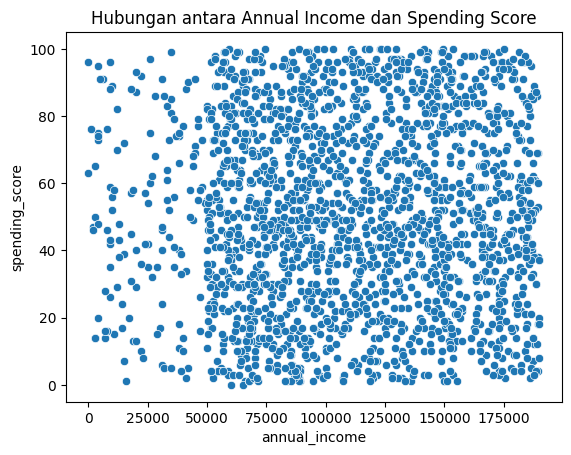

In [74]:
# cek outlier Annual Income-Spending Score


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [75]:
#Type your code here

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [76]:
#Type your code here

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [77]:
#Type your code here

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [78]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [79]:
#Type your code here

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [80]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.